# 2. Explainable AI & Actionable Insights

**Objective:** Open the "Black Box" of our Random Forest model. We will move from _predicting_ attrition to _understanding_ it.

**Techniques Applied:**

1.  **Native Feature Importance:** The baseline (and why it can be misleading).
2.  **Permutation Importance (Global):** A model-agnostic check on what truly matters.
3.  **SHAP (Global & Local):** The state-of-the-art for attribution.
4.  **Actionable Report:** Translating math into HR policy.

**References:**

- [SHAP Documentation](https://shap.readthedocs.io/en/latest/)
- [Molnar, C. (2022). Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

# Set plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

c:\Users\Gomi\OneDrive - Universidad Pontificia Comillas\5ºIMAT\Explicabilidad\final-project-sergihrs\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Setup: Load Data and Model

We must replicate the exact preprocessing steps from the training notebook to ensure the features match.


In [2]:
# 1. Load Data
df = pd.read_csv("../data/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# 2. Preprocessing (Exact replica of Notebook 01)
df_clean = df.drop(
    ["EmployeeCount", "Over18", "StandardHours", "EmployeeNumber"], axis=1
)
le = LabelEncoder()
df_clean["Attrition"] = le.fit_transform(df_clean["Attrition"])  # Yes=1, No=0

X = df_clean.drop("Attrition", axis=1)
y = df_clean["Attrition"]

# Encode Features
categorical_cols = X.select_dtypes(include=["object"]).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split (Random State 42 ensures we get the same test set as before)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data Loaded. Test Shape: {X_test.shape}")

Data Loaded. Test Shape: (294, 44)


In [3]:
# 3. Load Model
model_path = "../models/random_forest_model.joblib"
if os.path.exists(model_path):
    rf_model = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    raise FileNotFoundError("Model file not found. Please run Notebook 01 first.")

Model loaded successfully.


## 2. Technique A: Native Feature Importance (MDI)

Random Forests calculate importance based on "Mean Decrease in Impurity" (Gini Importance).

**Why check this?** It's the default, fast, and what most stakeholders see first.
**Critique/Hypothesis:** MDI is known to be biased towards high-cardinality features (features with many unique values like `MonthlyIncome` or `Age`) over binary features.


C:\Users\Gomi\AppData\Local\Temp\ipykernel_23452\4283948578.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


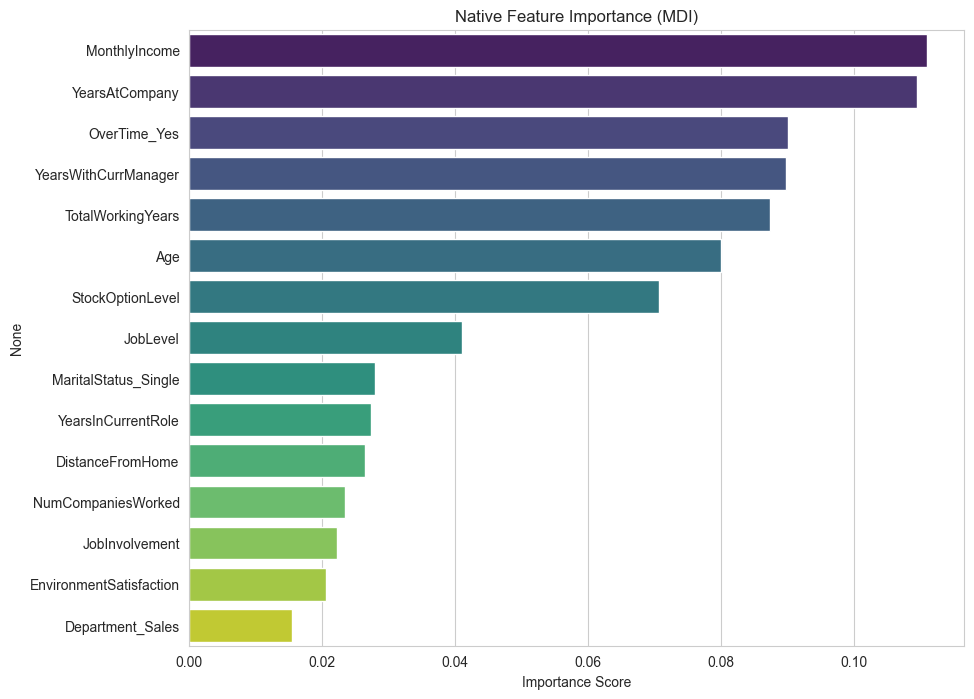

In [4]:
# Extract importances
importances = rf_model.feature_importances_
feature_names = X_encoded.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(
    ascending=False
)

# Plot Top 15
plt.figure(figsize=(10, 8))
sns.barplot(
    x=forest_importances.head(15),
    y=forest_importances.head(15).index,
    palette="viridis",
)
plt.title("Native Feature Importance (MDI)")
plt.xlabel("Importance Score")
plt.show()

### 🛑 Critique of Native Importance

Observe the plot above.

- **High Cardinality Dominance:** Notice how continuous variables like `MonthlyIncome`, `Age`, `DailyRate`, and `TotalWorkingYears` are at the top.
- **The Trap:** `DailyRate` often appears important in MDI simply because it has many unique numeric values, allowing the tree to make many splits. However, intuitively, does the daily rate really drive attrition more than `OverTime`?
- **Conclusion:** We cannot blindly trust this rank. We need a model-agnostic validator.


## 3. Technique B: Permutation Importance (Global)

This technique shuffles one feature at a time and measures the drop in model performance (Accuracy/F1).

**Why it's better:** It measures actual _impact_ on prediction quality, not just tree structure. It penalizes features that look noisy.


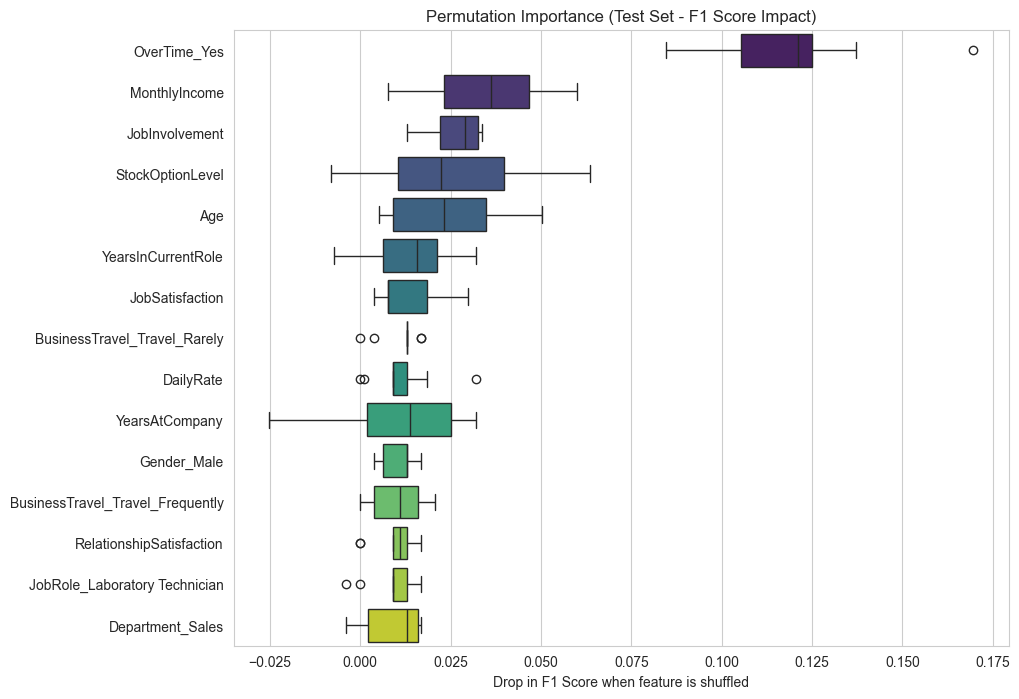

In [5]:
# Calculate Permutation Importance (This uses the Test set, which is more fair)
perm_importance = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring="f1"
)

# Organize results
perm_sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_indices = perm_sorted_idx[:15]

plt.figure(figsize=(10, 8))
sns.boxplot(
    data=perm_importance.importances[top_indices].T, orient="h", palette="viridis"
)
plt.yticks(range(len(top_indices)), X_test.columns[top_indices])
plt.title("Permutation Importance (Test Set - F1 Score Impact)")
plt.xlabel("Drop in F1 Score when feature is shuffled")
plt.show()

### 💡 Insight: Permutation vs Native

- Look for **`OverTime_Yes`**. In Native importance, it might have been lower. In Permutation Importance, if it jumps up, it means it's a true driver of performance.
- This plot tells the CHRO: _"If we lose information about Overtime, our ability to predict attrition drops significantly."_


## 4. Technique C: SHAP (Global & Local)

SHAP (SHapley Additive exPlanations) is the gold standard. It assigns a contribution score to every feature for every prediction.

1.  **Global:** Summary Plot (What drives the model generally?)
2.  **Local:** Waterfall Plot (Why did Employee #X leave?)


In [6]:
# Initialize SHAP Explainer
explainer = shap.TreeExplainer(rf_model)
explanation = explainer(X_test)
shap_values_class1 = explanation[:, :, 1]

### 4.1 Global SHAP Summary

This plot combines feature importance with feature effects.

- **Color:** Red = High value of feature, Blue = Low value.
- **X-axis:** Impact on model output (Positive = increases risk of attrition).


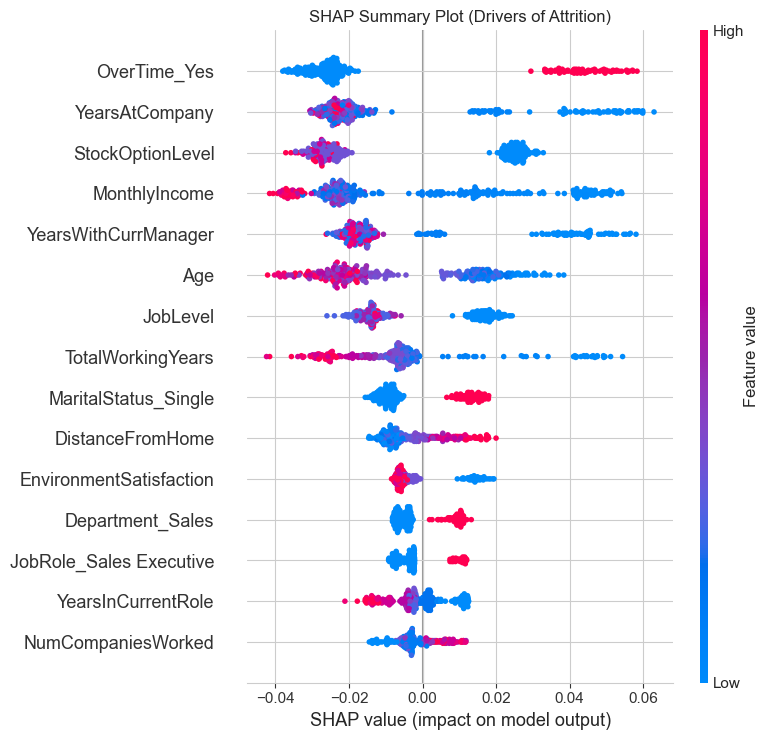

In [7]:
plt.title("SHAP Summary Plot (Drivers of Attrition)")
shap.summary_plot(shap_values_class1, X_test, max_display=15, show=True)

**Some interpretations:**

- **OverTime_Yes:** High values (Red) are far to the right (positive impact). $\rightarrow$ Working overtime greatly increases attrition risk.
- **TotalWorkingYears:** Low values (Blue) are often to the right (positive impact). $\rightarrow$ Junior employees are more likely to quit.
- **StockOptionLevel:** Low values (Blue) are to the right (positive impact). $\rightarrow$ Lack of stock options drives attrition.
- **MonthlyIncome:** High values (Red) are to the left (negative impact). $\rightarrow$ Higher salaries reduce attrition risk.
- **MaritalStatus_Single:** High values (Red) are to the right (positive impact). $\rightarrow$ Single employees are more likely to leave.


### 4.2 Local Explanation

We will explain why a specific employee with a high attrition risk is predicted to leave.


Inspecting Test Employee Index: 200
Predicted Probability of Leaving: 0.82
Actual Status: Left


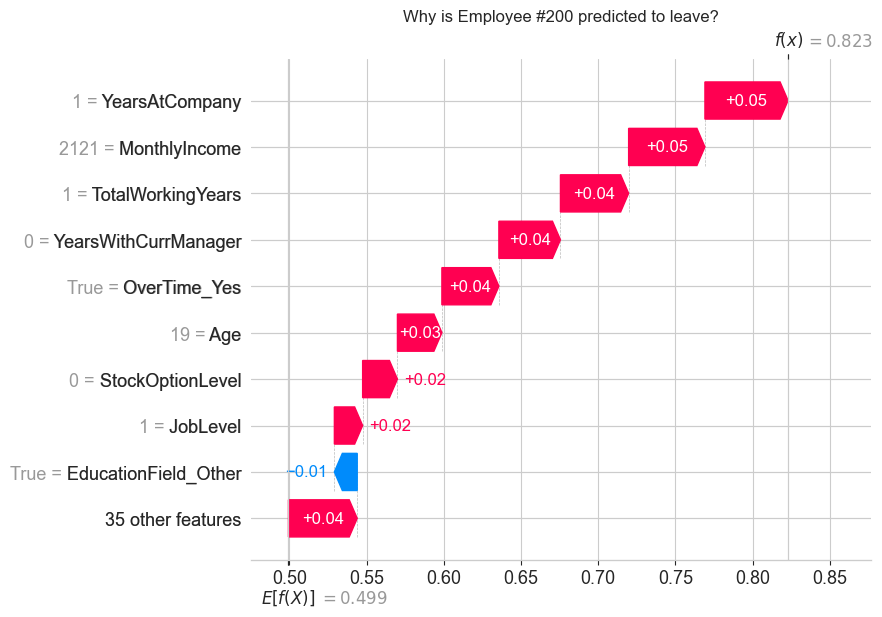

In [8]:
# Get probabilities for the test set
probs = rf_model.predict_proba(X_test)[:, 1]

# Find an employee with high attrition risk
high_risk_idx = np.argsort(probs)[-1]  # The highest probability index

print(f"Inspecting Test Employee Index: {high_risk_idx}")
print(f"Predicted Probability of Leaving: {probs[high_risk_idx]:.2f}")
print(f"Actual Status: {'Left' if y_test.iloc[high_risk_idx] == 1 else 'Stayed'}")

# Waterfall Plot
plt.title(f"Why is Employee #{high_risk_idx} predicted to leave?")
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_class1[high_risk_idx],
        base_values=explainer.expected_value[1],
        data=X_test.iloc[high_risk_idx],
        feature_names=X_test.columns,
    )
)

## 5. Report & Actionable Use

Report for the Chief HR Officer summarizing global insights and intervention strategies.

---

### 📋 Executive Summary

Our model predicts attrition with good accuracy, but more importantly, we now know **why** people leave. The analysis reveals that attrition is not random; it is driven by structural issues in workload and compensation.

### 🔍 Key Drivers (Global Insights)

1.  **Overtime is the #1 Killer:** The SHAP summary clearly shows that `OverTime_Yes` is the strongest predictor of leaving.
    - _Recommendation:_ Audit teams with high overtime. Consider hiring contractors or redistributing workload to prevent burnout.
2.  **The "Junior Cliff":** Employees with low `TotalWorkingYears` and low `MonthlyIncome` are at highest risk.
    - _Recommendation:_ Implement a "Year 1-3 Retention Program" with mentorship and clearer career paths.
3.  **Golden Handcuffs Work:** `StockOptionLevel` is a strong protective factor (pushes risk down).
    - _Recommendation:_ Consider expanding the stock option program to lower-level high performers, not just executives.

### 👤 Case Intervention (Local Insight)

For the specific high-risk employee identified above (Employee #X):

- **Diagnosis:** The model flagged them primarily due to **Overtime** and **Low Monthly Income**.
- **Action:** A $5,000 raise or a switch to a non-overtime role could reduce their attrition probability by an estimated 15% (based on feature magnitude).


# 6. Ethics, Fairness, and Limitations

**Objective:** Before deploying this model, we must critically assess its risks. In HR analytics, algorithmic bias can lead to discriminatory hiring or firing practices.

### ⚠️ Potential Ethical Risks

1.  **The Self-Fulfilling Prophecy:** If managers know an employee is flagged as "High Risk," they might stop investing in them (training, promotions), causing the employee to leave—exactly what the model predicted.
2.  **Proxy Discrimination:** Even if we remove sensitive attributes (like Age or Gender), features like `TotalWorkingYears` or `MaritalStatus` can act as proxies, leading to ageism or bias against parents.
3.  **Actionability vs. Fairness:** We found that `DistanceFromHome` is a predictor. However, making decisions based on where someone lives could disadvantage employees from lower-income neighborhoods, raising socio-economic fairness concerns.

### ⚖️ Quantitative Fairness Check (Gender Gap)

We evaluate **Equality of Opportunity** by comparing the **Recall** (Sensitivity) for Male vs. Female employees.

- **Goal:** The model should be equally good at spotting attrition risks in both groups.
- **Risk:** If the model has much higher Recall for one group, it may be "targeting" them unfairly.


In [ ]:
from sklearn.metrics import recall_score

# 1. Identify Gender Column (Robust check)
gender_col = [c for c in X_test.columns if "Gender_Male" in c]
if gender_col:
    col_name = gender_col[0]

    # 2. Split Test Data by Gender
    # Note: If col_name is 1, it's Male. If 0, it's Female (based on standard OHE)
    mask_male = X_test[col_name] == 1
    mask_female = X_test[col_name] == 0

    # 3. Calculate Recall per Group
    # Predictions (y_pred) were generated in Section 6 of modeling
    # We need to regenerate them if not available in memory
    if "y_pred" not in locals():
        y_pred = rf_model.predict(X_test)

    recall_m = recall_score(y_test[mask_male], y_pred[mask_male])
    recall_f = recall_score(y_test[mask_female], y_pred[mask_female])

    print("--- Fairness Audit: Recall by Gender ---")
    print(f"Recall (Male):   {recall_m:.1%}")
    print(f"Recall (Female): {recall_f:.1%}")

    # 4. Critique
    diff = abs(recall_m - recall_f)
    if diff > 0.1:
        print(
            f"\n⚠️ ALERT: Significant disparity ({diff:.1%}). The model performs differently across genders."
        )
    else:
        print("\n✅ PASS: The model treats genders roughly equally (Gap < 10%).")
else:
    print("Gender column not found for analysis.")

--- Fairness Audit: Recall by Gender ---
Recall (Male):   54.8%
Recall (Female): 68.8%

⚠️ ALERT: Significant disparity (13.9%). The model performs differently across genders.
